In [2]:
import numpy as np
from imageio import imread
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
from numpy.random import normal, uniform
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def FrankeFunctionWithNoise(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise

def create_X(x, y, n ):
    L = ['1']
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
            if (i == 0 and k == 0) :
                L.append('1')
            elif(i-k == 0):
                L.append('Y^' + str(k))
            elif (k == 0):
                L.append('X^' + str(i-k))
            elif (i==2 and k == 1):
                L.append('XY')
            elif(i-k == 1):
                L.append('X'+'Y^' + str(k))
            elif (k == 1):
                L.append('X^' + str(i-k)+'Y')
            else :
                L.append('X^' + str(i-k)+'Y^'+ str(k))
    return X, L

def plotFunction(x, y, z, title):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Plot the surface
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # Add a color bar which maps values to colors.
    fig.suptitle(title)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    

In [3]:
#################    DATA     ################
################# Parameters #################

poly = 7
N = 100 #number of data

##############################################

#terrain = imread('SRTM_data_Norway_2.tif')
#terrain = terrain[:N, :N]
#Creates mesh of image pixels
#x = np.linspace(0,1, np.shape(terrain)[0])
#y = np.linspace(0,1, np.shape(terrain)[1])
#z = terrain
#x_mesh, y_mesh = np.meshgrid(x,y)


x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
x_mesh, y_mesh = np.meshgrid(x,y)
z = FrankeFunctionWithNoise(x_mesh, y_mesh)


x_y = np.empty((len(x)*len(x), 2))
x_y[:, 0] = x_mesh.ravel()
x_y[:, 1] = y_mesh.ravel()

scaler = StandardScaler()
scaler.fit(x_y)
x_y = scaler.transform(x_y)
x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel(), test_size=0.2)

X_train, coeff = create_X(x_y_train[:, 0], x_y_train[:, 1], poly )
X_test, coeff = create_X(x_y_test[:, 0], x_y_test[:, 1], poly )
X , coeff = create_X(x_y[:, 0], x_y[:, 1], poly)

In [26]:
#--------- NN -----------#

np.random.seed(1) 

Cost = []

#Fonction d'activation sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Derive de notre fonction d'activation
def sigmoidPrime(x):
    return x * (1 - x)


#-------------------   Data
#Data inputs
inputs = X_train

#Data ouputs
outputs = z_train

#Data inputs
inputs_test = X
#-------------------

# Hessian Matrix
H = (2.0/N)* X_train.T @ X_train
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
eta_max = 1.0/np.max(EigValues)

#-------------------  Dimension of our NN
batch_size = 5
nb_input_neurons = inputs.shape[0]         #Number of neurons inputs
nb_hidden_neurons = 50                     #Number of neurons by hidden layer
nb_output_neurons = 1                   #Number of neurons outputs
nb_features = inputs.shape[1]
nb_epochs = 100
iterations = nb_input_neurons // batch_size
eta = eta_max
lmbd = 0.1
nb_categories = batch_size
#-------------------


#Initialization of weights


#===================================
#           Training
#===================================

hidden_weights_1 = np.random.randn(nb_features, nb_hidden_neurons)
hidden_bias_1 = np.zeros(nb_hidden_neurons) + 0.01
hidden_weights_2 = np.random.randn(nb_hidden_neurons, nb_hidden_neurons)
hidden_bias_2 = np.zeros(nb_hidden_neurons) + 0.01

output_weights = np.random.randn(nb_hidden_neurons, nb_categories)
output_bias = np.zeros(nb_categories) + 0.01

for i in range(1, nb_epochs+1):
    
    np.random.shuffle(inputs)
    np.random.shuffle(outputs)
    
    for j in range(iterations):
        
        # minibatch training data
        random_index = np.random.randint(iterations)
        X_data = inputs[random_index*batch_size:(random_index+1)*batch_size]
        Y_data = outputs[random_index*batch_size:(random_index+1)*batch_size]
        
        #----------------FEED FORWARD-----------------
        z_h_1 = np.matmul(X_data, hidden_weights_1) + hidden_bias_1
        a_h_1 = sigmoid(z_h_1)
        z_h_2 = np.matmul(a_h_1, hidden_weights_2) + hidden_bias_2
        a_h_2 = sigmoid(z_h_2)
        z_o = np.matmul(a_h_2, output_weights) + output_bias

        # ----------------BACKPROPAGATION-----------------
        
        error_output =  sigmoid(z_o) - Y_data
        print(error_output.shape)
        print(output_weights.shape)
        print(error_hidden_2.shape)
        print(hidden_weights_2.shape)
        error_hidden_2 = np.matmul(error_output, output_weights.T) * sigmoidPrime(a_h_2)
        error_hidden_1 = np.matmul(error_hidden_2, hidden_weights_2.T) * sigmoidPrime(a_h_1)


        output_weights_gradient = np.matmul(a_h_2.T, error_output)
        output_bias_gradient = np.sum(error_output, axis=0)
        
        hidden_weights_gradient_2 = np.matmul(a_h_1.T, error_hidden_2)
        hidden_bias_gradient_2 = np.sum(error_hidden_2, axis=0)

        hidden_weights_gradient_1 = np.matmul(X_data.T, error_hidden_1)
        hidden_bias_gradient_1 = np.sum(error_hidden_1, axis=0)

        if lmbd > 0.0:
            output_weights_gradient += lmbd * output_weights
            hidden_weights_gradient_1 += lmbd * hidden_weights_1
            hidden_weights_gradient_2 += lmbd * hidden_weights_2

        output_weights -= eta * output_weights_gradient
        output_bias -= eta * output_bias_gradient
        hidden_weights_1 -= eta * hidden_weights_gradient_1
        hidden_bias_1 -= eta * hidden_bias_gradient_1
        hidden_weights_2 -= eta * hidden_weights_gradient_2
        hidden_bias_2 -= eta * hidden_bias_gradient_2
        
    #Cost
    cost = np.mean(np.abs(error_output))
    print("Epoch "+str(i)+"/" +str(nb_epochs))
    print("Cost:", cost)
    print("----------")
    Cost.append(cost)

    
def feed_forward_out(X):
    # feed-forward for output
    z_h_1 = np.matmul(X, hidden_weights_1) + hidden_bias_1
    a_h_1 = sigmoid(z_h_1)
    z_h_2 = np.matmul(a_h_1, hidden_weights_2) + hidden_bias_2
    a_h_2 = sigmoid(z_h_2)
    z_o = np.matmul(a_h_2, output_weights) + output_bias
    return z_o

def predict(X):
    return feed_forward_out(X)


plt.plot(range(1, nb_epochs+1), Cost, 'r')
plt.title("Cost function")
plt.xlabel("Epoch")
plt.ylabel("Cost")

#===================================
#           Testing
#===================================


prediction = predict(X)
print(prediction.shape)
print("----")
print(z.shape)


#plotFunction(x_mesh, y_mesh, z.reshape(len(x), len(x)), "Data")
#plotFunction(x_mesh, y_mesh, prediction.reshape(len(x), len(x)), "Prediction")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 50)

Epoch 1/100
800/800 [==============================] - 1s 591us/step - loss: 0.7057
Epoch 2/100
800/800 [==============================] - 0s 577us/step - loss: 0.1392
Epoch 3/100
800/800 [==============================] - 0s 575us/step - loss: 0.0853
Epoch 4/100
800/800 [==============================] - 0s 577us/step - loss: 0.0751
Epoch 5/100
800/800 [==============================] - 0s 575us/step - loss: 0.0652
Epoch 6/100
800/800 [==============================] - 0s 577us/step - loss: 0.0556
Epoch 7/100
800/800 [==============================] - 0s 573us/step - loss: 0.0468
Epoch 8/100
800/800 [==============================] - 0s 587us/step - loss: 0.0395
Epoch 9/100
800/800 [==============================] - 0s 605us/step - loss: 0.0339
Epoch 10/100
800/800 [==============================] - 0s 594us/step - loss: 0.0297
Epoch 11/100
800/800 [==============================] - 0s 612us/step - loss: 0.0268
Epoch 12/100
800/800 [==============================] - 0s 592us/step - lo

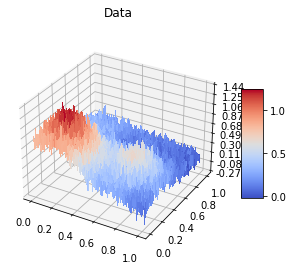

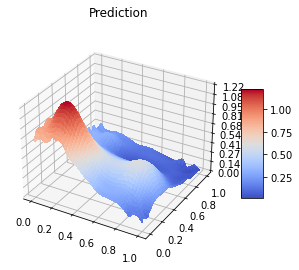

In [11]:
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


n_hidden_neurons = 32
batch_size = 10
epochs = 100
activation_function = 'sigmoid'
optimizer = tf.keras.optimizers.Adam(learning_rate= eta_max)


model = Sequential()
model.add(Dense(n_hidden_neurons, activation = activation_function, input_dim = X_train.shape[1]))
model.add(Dense(units = n_hidden_neurons, activation = activation_function))
model.add(Dense(units = n_hidden_neurons, activation = activation_function))
model.add(Dense(units = 1))
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.fit(X_train, z_train, batch_size = batch_size, epochs = epochs)
z_plot = model.predict(X)
plotFunction(x_mesh, y_mesh, z.reshape(len(x), len(x)), "Data")
plotFunction(x_mesh, y_mesh, z_plot.reshape(len(x), len(x)), "Prediction")
plt.show()